<a href="https://colab.research.google.com/github/neemiasbsilva/MLLMs-Teoria-e-Pratica/blob/main/use-cases/IdentifyFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepSeek VL - Identificação de objetos

Bem vindos a esse notebook com um pequeno tutorial para inferência em uma LLM multimodal, com um pedacinho de interface com pandas!

É muito importante que cada célula seja executada em sequência, conforme será explicado em logo mais.

Neste tutorial, devido às limitações do google Collab, vamos utilizar o [Deepseek-VL](https://github.com/deepseek-ai/DeepSeek-VL). Então, Vamos começar clonando seu repositório:

## Configuração do Ambiente

In [ ]:
!git clone https://github.com/deepseek-ai/DeepSeek-VL -q

fatal: destination path 'DeepSeek-VL' already exists and is not an empty directory.


Em seguida, vamos instalar as dependências, tomando cuidado para instalar o Torch separado, já que este é sensível a versão que estamos utilizando de Python:

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 -q
!sed -i '/torch==/d' /content/DeepSeek-VL/requirements.txt
!pip install -r /content/DeepSeek-VL/requirements.txt -q

Após a instalação precisa reinicar a execução para que os pacotes necessários sejam devidamente instalados no kernel

## Carregar o Modelo e Inicialização do Tokenizer

Agora, vamos utilizar os métodos da biblioteca transformers e o torch para carregar o modelo na nossa placa gráfica, inicializar nosso tokenizer, que será responsável pela codificação das entradas, e decodificação das saídas para o modelo:

In [ ]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/content/DeepSeek-VL')

import torch
from transformers import AutoModelForCausalLM

from deepseek_vl.models import VLChatProcessor, MultiModalityCausalLM

model_path = "deepseek-ai/deepseek-vl-1.3b-base"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

Python version is above 3.10, patching the collections module.


preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

## Carregando o Modelo e Fazendo um Teste de Infêrencia

Vamos rodar este teste para verificar se o modelo está carregado corretamente! Note a reposta sendo mostrada no terminal, e todo o pré-processamento que um modelo multimodal exige, como criação dos embeddings das imagens:

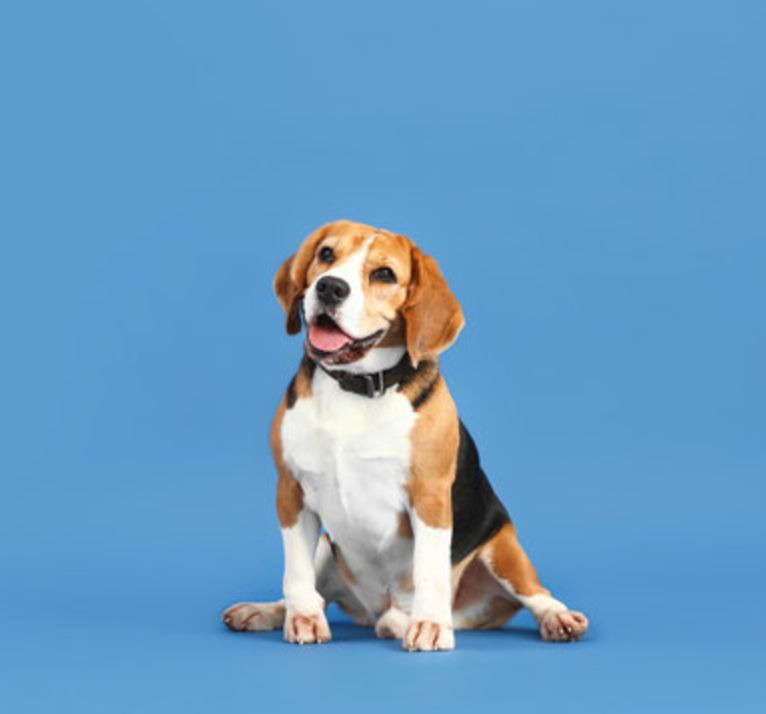

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

User: <image_placeholder>Analyze the image and identify which of the features you are certain are in this list and in the image: [dog, cat, rat, bird, sheep]. Do not mention features not in the list.

Assistant:  The image features a dog sitting on a blue background. The dog is brown and white in color. It has a black collar around its neck. The dog's tongue is sticking out, and it appears to be smiling. The dog is sitting on a white surface. The image does not contain any other objects or features. The dog is the only object in the image. The dog is the main focus of the image. The dog's position and the dog's expression are the only features in the image. The image does not contain any text. The image does not contain any other objects or features. The image does not contain any text. The image does

In [ ]:
from deepseek_vl.utils.io import load_pil_images
from IPython.display import Image, display

conversation = [
    {
        "role": "User",
        "content": """<image_placeholder>Analyze the image and identify which of the features you are certain are in this list and in the image: [dog, cat, rat, bird, sheep]. Do not mention features not in the list.
        """,
        "images": ["/content/DeepSeek-VL/images/dog_a.png"]
    },
    {
        "role": "Assistant",
        "content": ""
    }
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation,
    images=pil_images,
    force_batchify=True
).to(vl_gpt.device)

# run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True
)

display(Image("/content/DeepSeek-VL/images/dog_a.png"))

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)

## Inferência em Batch

Caso dê tudo certo, vamos agora tentar um processamento em batch.

Como já foi detalhado no material, vamos focar na task 1. então focamos puramente em passar a imagem, e um prompt para o modelo.

Neste exemplo, utilizamos o subconjunto alpha5 p3, onde todos os 5 examinadores concordaram no sentimento de uma imagem, com três classes.

Mais detalhes, e acesso para essa base de dados completa podem ser acessados [aqui](https://arxiv.org/abs/2508.16873)

In [ ]:
import pandas as pd
from io import BytesIO
base_url = "https://drive.usercontent.google.com/download?export=view&id="
ids = ["1mKb_EHSAgsOmxJsTFleVUvtGv4Uj8KQ0", "1UHIfdHUFkOsamfVcL_QwAG7TFc_gNwqk", "1QcaUZ0Ac-XsUmZvv-sIZr8x1waK7gnwL", "1o3a37CSBkb8uuPbg7xEItMc-47ZksmNl", "1_cDlBPgjCkokLs3xSLihxAys6WuWIDnW"]


Depois de carregado nosso conjunto, vamos passar por cada uma das imagens, passando para o modelo a imagem, e o nosso prompt, propriamente preparado, e mostrar a reposta dele! Note que para esse modelo, extrair o sentimento exato da resposta não é uma tarefa simples, mas em modelos mais avançados, essa tarefa se torna um pouco mais fácil, já que tendem a dar uma resposta mais assertiva.

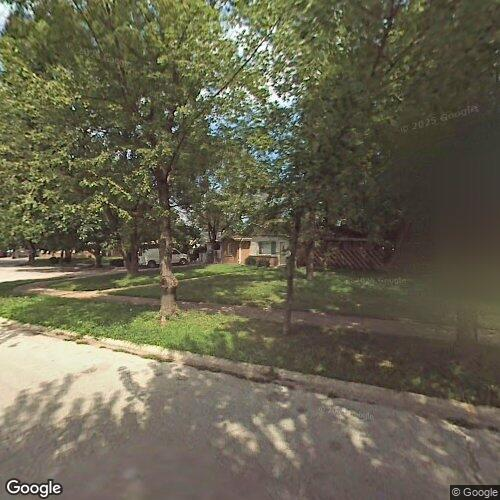

--- id: 1mKb_EHSAgsOmxJsTFleVUvtGv4Uj8KQ0---
You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

User: <image_placeholder>Analyze the image and provide a list of features that you are certain are present in the image. Ignore features not in the provided list.
        
        PROVIDED LIST: 
        [sidewalk, tree-lined street, porch, fenced front yard, attached garage, cul-de-sac, hills, private front entrance]

        EXAMPLE OUTPUT:
        [sidewalk, porch, attached garage]

Assistant:  The image you provided is a street scene with a sidewalk, a tree-lined street, a porch, a fenced front yard, an attached garage, a cul-de-sac, hills, and a private front entrance. The image does not contain any features that are not mentioned in the provided list.
---------


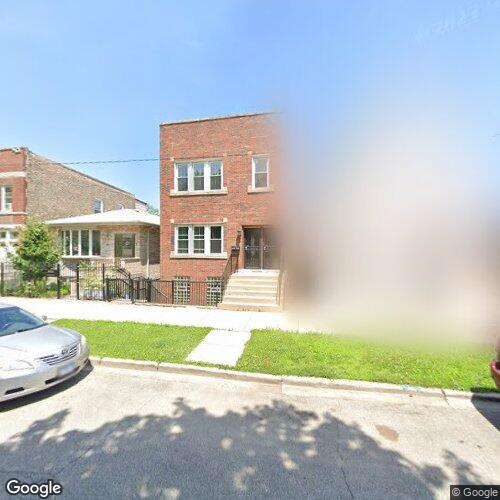

--- id: 1UHIfdHUFkOsamfVcL_QwAG7TFc_gNwqk---
You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

User: <image_placeholder>Analyze the image and provide a list of features that you are certain are present in the image. Ignore features not in the provided list.
        
        PROVIDED LIST: 
        [sidewalk, tree-lined street, porch, fenced front yard, attached garage, cul-de-sac, hills, private front entrance]

        EXAMPLE OUTPUT:
        [sidewalk, porch, attached garage]

Assistant:  The image shows a residential street with a sidewalk, a tree-lined street, a porch, a fenced front yard, an attached garage, a cul-de-sac, hills, and a private front entrance. The street appears to be in a residential area, and there are no cars visible in the image. The image does not provide any information about the weather or time of day.
---------


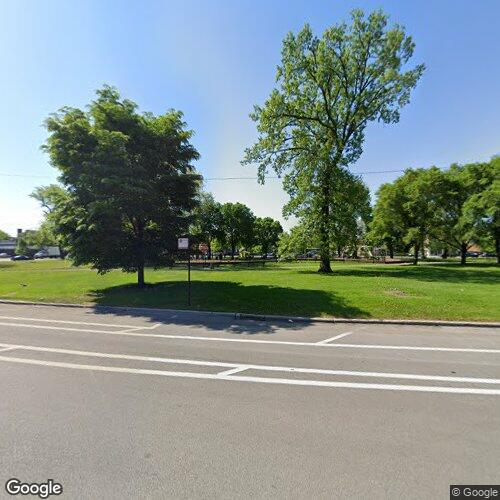

--- id: 1QcaUZ0Ac-XsUmZvv-sIZr8x1waK7gnwL---
You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

User: <image_placeholder>Analyze the image and provide a list of features that you are certain are present in the image. Ignore features not in the provided list.
        
        PROVIDED LIST: 
        [sidewalk, tree-lined street, porch, fenced front yard, attached garage, cul-de-sac, hills, private front entrance]

        EXAMPLE OUTPUT:
        [sidewalk, porch, attached garage]

Assistant:  The image shows a residential street with a sidewalk, a porch, and an attached garage. There are also trees lining the street, and a fenced front yard. The street appears to be in a residential area with hills in the background. The image does not provide any information about the front entrance of the house.
---------


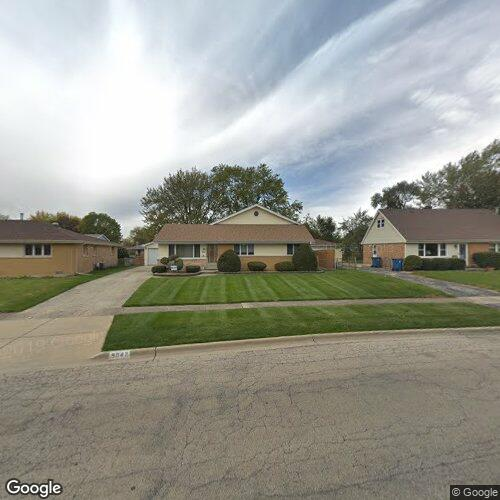

--- id: 1o3a37CSBkb8uuPbg7xEItMc-47ZksmNl---
You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

User: <image_placeholder>Analyze the image and provide a list of features that you are certain are present in the image. Ignore features not in the provided list.
        
        PROVIDED LIST: 
        [sidewalk, tree-lined street, porch, fenced front yard, attached garage, cul-de-sac, hills, private front entrance]

        EXAMPLE OUTPUT:
        [sidewalk, porch, attached garage]

Assistant:  The image shows a residential area with a sidewalk, a tree-lined street, a fenced front yard, an attached garage, a cul-de-sac, and a private front entrance. The area appears to be in a suburban neighborhood with hills in the background.
---------


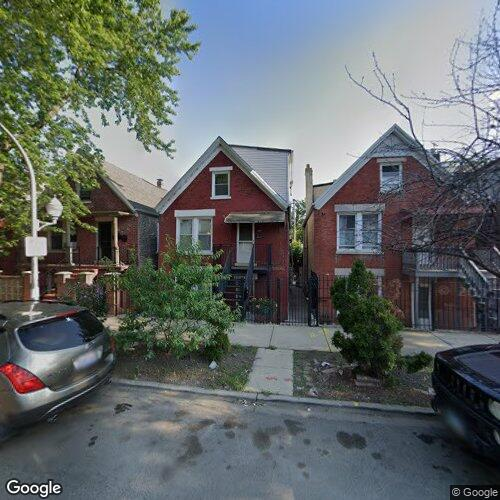

--- id: 1_cDlBPgjCkokLs3xSLihxAys6WuWIDnW---
You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

User: <image_placeholder>Analyze the image and provide a list of features that you are certain are present in the image. Ignore features not in the provided list.
        
        PROVIDED LIST: 
        [sidewalk, tree-lined street, porch, fenced front yard, attached garage, cul-de-sac, hills, private front entrance]

        EXAMPLE OUTPUT:
        [sidewalk, porch, attached garage]

Assistant:  The image shows a residential street with a sidewalk, a tree-lined street, a fenced front yard, a porch, and an attached garage. There is also a private front entrance. The street appears to be in a residential area with hills in the background.
---------


In [ ]:
import requests
import base64

for id in ids:
  image_url = base_url + id
  response = requests.get(image_url)
  b64response = uri = ("data:" +
                response.headers['Content-Type'] + ";" +
                "base64," + str(base64.b64encode(response.content).decode("utf-8")))

  conversation = [
    {
        "role": "User",
        "content": """<image_placeholder>Analyze the image and provide a list of features that you are certain are present in the image. Ignore features not in the provided list.

        PROVIDED LIST:
        [sidewalk, tree-lined street, porch, fenced front yard, attached garage, cul-de-sac, hills, private front entrance]

        EXAMPLE OUTPUT:
        [sidewalk, porch, attached garage]
        """,
        "images": [b64response]
    },
    {
        "role": "Assistant",
        "content": ""
    }
  ]

  pil_images = load_pil_images(conversation)
  prepare_inputs = vl_chat_processor(
      conversations=conversation,
      images=pil_images,
      force_batchify=True
  ).to(vl_gpt.device)

  inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

  outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True
  )

  answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
  display(Image(data = response.content))
  print('--- id: ' + id + '---')
  print(f"{prepare_inputs['sft_format'][0]}", answer)
  print('---------')


